In [11]:
import pandas as pd
import numpy as np

In [12]:
path = "../data/train.csv"
df = pd.read_csv(path, parse_dates=[0])
df

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4
1,2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0
2,2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9
3,2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1
4,2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6
...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3
40987,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0
40988,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1
40989,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4


In [13]:
df = df.rename(columns={"id": "date"})
df = df.drop_duplicates()

In [14]:
# Generating year, month, date, hour, weekday number and weekend columns

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.weekday
df["weekend"] = df['weekday'].isin([5, 6])

In [15]:
# Checking for missing values

df.isna().sum()

date               0
valeur_NO2      3297
valeur_CO      12529
valeur_O3        693
valeur_PM10     7167
valeur_PM25     1791
day                0
month              0
year               0
hour               0
weekday            0
weekend            0
dtype: int64

In [16]:
# Using interpolation to fill in missing values before adding lag features

linear_int = df[["date", "valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]]
linear_int = linear_int.set_index("date")
new_features = linear_int.resample('1h').interpolate("linear")

df = df.merge(new_features, on="date", how="left")
df = df.rename(columns={'valeur_NO2_y': 'valeur_NO2', 'valeur_CO_y': 'valeur_CO', 'valeur_O3_y': 'valeur_O3', 'valeur_PM10_y': 'valeur_PM10',
       'valeur_PM25_y': 'valeur_PM25'})
df = df.drop(['valeur_NO2_x', 'valeur_CO_x', 'valeur_O3_x', 'valeur_PM10_x',
       'valeur_PM25_x'], axis=1)

In [17]:
# Generating lag columns

df["valeur_NO2_lag1"] = df['valeur_NO2'].shift(1)
df["valeur_CO_lag1"] = df['valeur_CO'].shift(1)
df["valeur_O3_lag1"] = df['valeur_O3'].shift(1)
df["valeur_PM10_lag1"] = df['valeur_PM10'].shift(1)
df["valeur_PM25_lag1"] = df['valeur_PM25'].shift(1)

df["valeur_NO2_lag2"] = df['valeur_NO2'].shift(12)
df["valeur_CO_lag2"] = df['valeur_CO'].shift(12)
df["valeur_O3_lag2"] = df['valeur_O3'].shift(12)
df["valeur_PM10_lag2"] = df['valeur_PM10'].shift(12)
df["valeur_PM25_lag2"] = df['valeur_PM25'].shift(12)

df["valeur_NO2_lag3"] = df['valeur_NO2'].shift(24)
df["valeur_CO_lag3"] = df['valeur_CO'].shift(24)
df["valeur_O3_lag3"] = df['valeur_O3'].shift(24)
df["valeur_PM10_lag3"] = df['valeur_PM10'].shift(24)
df["valeur_PM25_lag3"] = df['valeur_PM25'].shift(24)

# Filling NaNs

df['valeur_NO2_lag1'] = df['valeur_NO2_lag1'].fillna(df['valeur_NO2'])
df['valeur_CO_lag1'] = df['valeur_CO_lag1'].fillna(df['valeur_CO'])
df['valeur_O3_lag1'] = df['valeur_O3_lag1'].fillna(df['valeur_O3'])
df['valeur_PM10_lag1'] = df['valeur_PM10_lag1'].fillna(df['valeur_PM10'])
df['valeur_PM25_lag1'] = df['valeur_PM25_lag1'].fillna(df['valeur_PM25'])

df['valeur_NO2_lag2'] = df['valeur_NO2_lag2'].fillna(df['valeur_NO2'])
df['valeur_CO_lag2'] = df['valeur_CO_lag2'].fillna(df['valeur_CO'])
df['valeur_O3_lag2'] = df['valeur_O3_lag2'].fillna(df['valeur_O3'])
df['valeur_PM10_lag2'] = df['valeur_PM10_lag2'].fillna(df['valeur_PM10'])
df['valeur_PM25_lag2'] = df['valeur_PM25_lag2'].fillna(df['valeur_PM25'])

df['valeur_NO2_lag3'] = df['valeur_NO2_lag3'].fillna(df['valeur_NO2'])
df['valeur_CO_lag3'] = df['valeur_CO_lag3'].fillna(df['valeur_CO'])
df['valeur_O3_lag3'] = df['valeur_O3_lag3'].fillna(df['valeur_O3'])
df['valeur_PM10_lag3'] = df['valeur_PM10_lag3'].fillna(df['valeur_PM10'])
df['valeur_PM25_lag3'] = df['valeur_PM25_lag3'].fillna(df['valeur_PM25'])

In [18]:
# Adding holidays data

holidays_path = "../data/fr-en-calendrier-scolaire.csv"
holidays = pd.read_csv(holidays_path, sep=";")

# Consider only metropolitan areas
holidays = holidays[holidays["Zones"].isin(["Zone C"])]

# Consider only relevant years
holidays = holidays[holidays["annee_scolaire"].isin(["2020-2021", "2021-2022"])]

# Distinguish for holidays in Paris or not
holidays['Holidays in Paris'] = 1

holidays.drop(["Académies","Population", "Zones"], axis=1, inplace = True)

# Convert to same date format
holidays['Date de début'] = holidays['Date de début'].apply(lambda x: x[0:10]+' '+x[11:19])
holidays['Date de fin'] = holidays['Date de fin'].apply(lambda x: x[0:10]+' '+x[11:19])

holidays["Date de début"] = pd.to_datetime(holidays["Date de début"], format='%Y-%m-%d %H:%M:%S')
holidays["Date de fin"] = pd.to_datetime(holidays["Date de fin"], format='%Y-%m-%d %H:%M:%S')

# Remove holidays starting after final date of dataset
holidays = holidays[holidays["Date de début"].dt.year != 2022]

# Remove summer holidays
holidays = holidays[holidays["Description"] != "Vacances d'Été"]
holidays.drop(["Description","annee_scolaire"], axis=1, inplace=True)

# Drop same holidays
holidays = holidays.drop_duplicates(subset=['Date de début', 'Date de fin'], keep='first')

# Create holidays date ranges 
ranges = []
for x in holidays[["Date de début","Date de fin"]].values:
    ranges.append(pd.date_range(x[0], x[1], freq="h"))
    
    
def is_date_within_ranges(date, ranges):
    for date_range in ranges:
        if date_range[0] <= date <= date_range[-1]:
            return 1
    return 0

# Apply the function to create a new column indicating whether the date is within any holiday range
df['holiday'] = df['date'].apply(lambda x: is_date_within_ranges(x, ranges))

In [19]:
# Taking into account rush hours for traffic

def is_rush_hour(x):
    if ((7 <= x.hour <= 9) or (16 <= x.hour <= 19)):
        return 1
    else:
        return 0

df['rush_hour'] = df['date'].apply(lambda x: is_rush_hour(x))

In [20]:
# Using the traffic data

traffic_path = "../data/traffic_data.csv"
traffic = pd.read_csv(traffic_path, sep=";")

traffic.drop("Unnamed: 0", axis=1, inplace=True)
traffic["date"] = pd.to_datetime(traffic["date"])

traffic = traffic.drop_duplicates(subset=["date"])
linear_int2 = traffic[["date", 'flow', 'occupation_rate']]
linear_int2 = linear_int2.set_index("date")
new_features2 = linear_int2.resample('1h').interpolate("linear")

df = df.merge(new_features2, on="date", how="left")

df["flow"] = df["flow"].fillna(df["flow"].mean())
df["occupation_rate"] = df["occupation_rate"].fillna(df["occupation_rate"].mean())

FileNotFoundError: [Errno 2] No such file or directory: '../data/traffic_data.csv'

## Lockdown  and Curfew features
We expect to have less air pollution during the lockdown Covid period and the curfews.

In [21]:
# Lockdown date range
start_date = pd.to_datetime('2020-10-31')
end_date = pd.to_datetime('2020-12-14')
start_date1 = pd.to_datetime('2021-04-04')
end_date1 = pd.to_datetime('2021-05-02')

# Create a new column and assign 1 if the date is within the specified range, otherwise 0
df['lockdown'] = df['date'].apply(lambda x: 1 if ((start_date <= x <= end_date) or (start_date1 <= x <= end_date1)) else 0)

In [22]:
# Curfew date range 
curfew_periods = [
    (pd.to_datetime('2020-10-17 22:00'), pd.to_datetime('2020-10-29 07:00')),
    (pd.to_datetime('2020-12-16 21:00'), pd.to_datetime('2021-01-15 07:00')),
    (pd.to_datetime('2021-01-16 19:00'), pd.to_datetime('2021-03-20 07:00')),
    (pd.to_datetime('2021-03-21 20:00'), pd.to_datetime('2021-04-02 07:00')),
    (pd.to_datetime('2021-05-19 22:00'), pd.to_datetime('2021-06-08 07:00')),
    (pd.to_datetime('2021-06-09 23:00'), pd.to_datetime('2021-06-20 07:00'))
]

df['curfew'] = 0  

# Loop through curfew periods and set Curfew column accordingly
for start_time, end_time in curfew_periods:
    mask = df[df['date'].between(start_time, end_time)]
    mask = mask[(mask["date"].dt.hour > start_time.hour) | (mask["date"].dt.hour < end_time.hour)]
    df.loc[mask.index, 'curfew'] = 1

# Weather data

In [23]:
df_weather1 = pd.read_csv("https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/HOR/H_75_previous-2020-2022.csv.gz", sep=';')
df_weather2 = pd.read_csv("https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/HOR/H_75_latest-2023-2024.csv.gz", sep=';')
df_weather = pd.concat([df_weather1, df_weather2])

In [24]:
col_list = []
for col in df_weather.columns:
    num_nan = pd.isna(df_weather[col]).sum()
    if num_nan == len(df_weather):
        col_list.append(col)
        print(f'Column {col} has {num_nan} missing values.')
print(col_list)

Column FF2 has 253097 missing values.
Column QFF2 has 253097 missing values.
Column DD2 has 253097 missing values.
Column QDD2 has 253097 missing values.
Column FXI2 has 253097 missing values.
Column QFXI2 has 253097 missing values.
Column DXI2 has 253097 missing values.
Column QDXI2 has 253097 missing values.
Column HXI2 has 253097 missing values.
Column QHXI2 has 253097 missing values.
Column DXI3S has 253097 missing values.
Column DHUMEC has 253097 missing values.
Column QDHUMEC has 253097 missing values.
Column GEOP has 253097 missing values.
Column QGEOP has 253097 missing values.
Column N has 253097 missing values.
Column QN has 253097 missing values.
Column NBAS has 253097 missing values.
Column QNBAS has 253097 missing values.
Column CL has 253097 missing values.
Column QCL has 253097 missing values.
Column CM has 253097 missing values.
Column QCM has 253097 missing values.
Column CH has 253097 missing values.
Column QCH has 253097 missing values.
Column N1 has 253097 missing v

In [25]:
df_weather = df_weather.drop(columns=['FF2', 'QFF2', 'DD2', 'QDD2', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'DXI3S',
                                      'DHUMEC', 'QDHUMEC', 'GEOP', 'QGEOP', 'N', 'QN', 'NBAS', 'QNBAS', 'CL', 'QCL', 'CM', 'QCM',
                                      'CH', 'QCH', 'N1', 'QN1', 'C1', 'QC1', 'B1', 'QB1', 'N2', 'QN2', 'C2', 'QC2', 'B2', 'QB2',
                                      'N3', 'QN3', 'C3', 'QC3', 'B3', 'QB3', 'N4', 'QN4', 'C4', 'QC4', 'B4', 'QB4', 'W1', 'QW1',
                                      'W2', 'QW2', 'SOL', 'QSOL', 'SOLNG', 'QSOLNG', 'TMER', 'QTMER', 'VVMER', 'QVVMER', 'ETATMER',
                                      'QETATMER', 'DIRHOULE', 'QDIRHOULE', 'HVAGUE', 'QHVAGUE', 'PVAGUE', 'QPVAGUE', 'HNEIGEF', 'QHNEIGEF',
                                      'TSNEIGE', 'QTSNEIGE', 'TUBENEIGE', 'QTUBENEIGE', 'HNEIGEFI3', 'QHNEIGEFI3', 'HNEIGEFI1', 'QHNEIGEFI1',
                                      'ESNEIGE', 'QESNEIGE', 'CHARGENEIGE', 'QCHARGENEIGE', 'DIR', 'QDIR', 'DIR2', 'QDIR2', 'DIF', 'QDIF',
                                      'DIF2', 'QDIF2', 'UV', 'QUV', 'UV2', 'QUV2', 'UV_INDICE', 'QUV_INDICE', 'INFRAR', 'QINFRAR', 'INFRAR2',
                                      'QINFRAR2', 'TLAGON', 'QTLAGON', 'TVEGETAUX', 'QTVEGETAUX', 'ECOULEMENT', 'QECOULEMENT', 'NUM_POSTE',
                                      'NOM_USUEL', 'LAT', 'LON'])

In [26]:
df_weather["date"] = pd.to_datetime(df_weather["AAAAMMJJHH"], format="%Y%m%d%H")
df_weather = df_weather.drop(columns=["AAAAMMJJHH", "HXI", "HXY", "HFXI3S", "HTN", "HTX", "HUN", "HUX"])

avg = df_weather.drop(
    columns=['RR1', 'NEIGETOT','QNEIGETOT']
       ).groupby("date").mean().reset_index()

tot = df_weather.drop(
    columns=['ALTI', 'QRR1', 'DRR1', 'QDRR1', 'FF', 'QFF', 'DD',
       'QDD', 'FXY', 'QFXY', 'DXY', 'QDXY', 'QHXY', 'FXI', 'QFXI',
       'DXI', 'QDXI', 'QHXI', 'FXI3S', 'QFXI3S', 'QDXI3S',
       'QHFXI3S', 'T', 'QT', 'TD', 'QTD', 'TN', 'QTN', 'QHTN', 'TX',
       'QTX', 'QHTX', 'DG', 'QDG', 'T10', 'QT10', 'T20', 'QT20', 'T50',
       'QT50', 'T100', 'QT100', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50',
       'TCHAUSSEE', 'QTCHAUSSEE', 'U', 'QU', 'UN', 'QUN', 'QHUN', 'UX',
       'QUX', 'QHUX', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80',
       'TSV', 'QTSV', 'PMER', 'QPMER', 'PSTAT', 'QPSTAT', 'PMERMIN',
       'QPMERMIN', 'VV', 'QVV', 'DVV200', 'QDVV200', 'WW', 'QWW',
       'GLO', 'QGLO', 'GLO2', 'QGLO2', 'INS', 'QINS', 'INS2',
       'QINS2']
       ).groupby("date").sum().reset_index()

df_weather = df_weather.drop_duplicates(subset=["date"])

df = df.merge(df_weather, on="date", how="left")

In [27]:
col_list = []
for col in df.columns:
    num_nan = pd.isna(df[col]).sum()
    if num_nan > 40000:
        col_list.append(col)
        print(f'Column {col} has {num_nan} missing values.')
print(col_list)

Column DRR1 has 40991 missing values.
Column QDRR1 has 40562 missing values.
Column FF has 40991 missing values.
Column QFF has 40991 missing values.
Column DD has 40991 missing values.
Column QDD has 40991 missing values.
Column FXY has 40991 missing values.
Column QFXY has 40991 missing values.
Column DXY has 40991 missing values.
Column QDXY has 40991 missing values.
Column QHXY has 40991 missing values.
Column FXI has 40991 missing values.
Column QFXI has 40991 missing values.
Column DXI has 40991 missing values.
Column QDXI has 40991 missing values.
Column QHXI has 40991 missing values.
Column FXI3S has 40991 missing values.
Column QFXI3S has 40991 missing values.
Column QDXI3S has 40991 missing values.
Column QHFXI3S has 40991 missing values.
Column TD has 40991 missing values.
Column QTD has 40991 missing values.
Column T10 has 40991 missing values.
Column QT10 has 40991 missing values.
Column T20 has 40991 missing values.
Column QT20 has 40991 missing values.
Column T50 has 409

In [28]:
df = df.drop(columns=['DRR1', 'FF', 'QFF', 'DD', 'QDD', 'FXY', 'QFXY', 'DXY', 'QDXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI',
                      'QHXI', 'FXI3S', 'QFXI3S', 'QDXI3S', 'QHFXI3S', 'TD', 'QTD', 'T10', 'QT10', 'T20', 'QT20', 'T50', 'QT50',
                      'T100', 'QT100', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'TCHAUSSEE', 'QTCHAUSSEE', 'U', 'QU', 'UN', 'QUN', 'QHUN',
                      'UX', 'QUX', 'QHUX', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80', 'TSV', 'QTSV', 'PMER', 'QPMER', 'PSTAT', 'QPSTAT',
                      'PMERMIN', 'QPMERMIN', 'VV', 'QVV', 'DVV200', 'QDVV200', 'WW', 'QWW', 'NEIGETOT', 'QNEIGETOT', 'GLO', 'QGLO', 'GLO2',
                      'QGLO2', 'INS', 'QINS', 'INS2', 'QINS2', 'QDRR1'])

In [29]:
# Filling missing values for weather data with their mean as there are very few

is_na = df.isna().sum()

for col in is_na.index:
    if is_na[col] > 0:
        df[col] = df[col].fillna(df[col].mean())

In [30]:
df.set_index("date", inplace=True)

# Preprocessing data

In [31]:
from sklearn.model_selection import train_test_split

X = df.drop(['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25'], axis=1) 
y = df[['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42, shuffle=False)

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from feature_engine.creation import CyclicalFeatures

numerical_features = ['valeur_NO2_lag1', 'valeur_CO_lag1', 'valeur_O3_lag1',
       'valeur_PM10_lag1', 'valeur_PM25_lag1', 'valeur_NO2_lag2',
       'valeur_CO_lag2', 'valeur_O3_lag2', 'valeur_PM10_lag2',
       'valeur_PM25_lag2', 'valeur_NO2_lag3', 'valeur_CO_lag3',
       'valeur_O3_lag3', 'valeur_PM10_lag3', 'valeur_PM25_lag3']

full_pipeline = ColumnTransformer([
        ("num", MinMaxScaler(), numerical_features), 
    ], remainder='passthrough').set_output(transform='pandas')

data_train_prepared = full_pipeline.fit_transform(X_train)
data_test_prepared = full_pipeline.transform(X_test)

In [33]:
# Save data

data_train_prepared.to_csv("../processed_data/data_train_prepared.csv", index=True)
data_test_prepared.to_csv("../processed_data/data_test_prepared.csv", index=True)
y_train.to_csv("../processed_data/y_train.csv", index=True)
y_test.to_csv("../processed_data/y_test.csv", index=True)

In [41]:
df.columns

Index(['day', 'month', 'year', 'hour', 'weekday', 'weekend', 'valeur_NO2',
       'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25',
       'valeur_NO2_lag1', 'valeur_CO_lag1', 'valeur_O3_lag1',
       'valeur_PM10_lag1', 'valeur_PM25_lag1', 'valeur_NO2_lag2',
       'valeur_CO_lag2', 'valeur_O3_lag2', 'valeur_PM10_lag2',
       'valeur_PM25_lag2', 'valeur_NO2_lag3', 'valeur_CO_lag3',
       'valeur_O3_lag3', 'valeur_PM10_lag3', 'valeur_PM25_lag3', 'holiday',
       'rush_hour', 'lockdown', 'curfew', 'ALTI', 'RR1', 'QRR1', 'T', 'QT',
       'TN', 'QTN', 'QHTN', 'TX', 'QTX', 'QHTX', 'DG', 'QDG'],
      dtype='object')

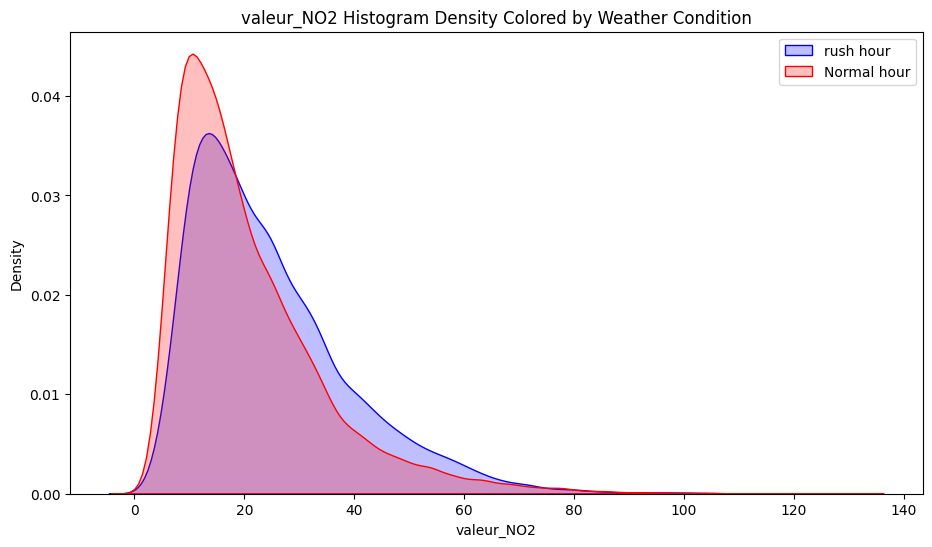

In [45]:
# Importing useful libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (11,6))

sns.kdeplot(
    df[df['rush_hour'] == 1]['valeur_NO2'],
    color='blue', label='rush hour', fill=True
)
sns.kdeplot(
    df[df['rush_hour'] == 0]['valeur_NO2'],
    color='red', label='Normal hour', fill=True
)

ax.set_xlabel('valeur_NO2')
ax.set_ylabel('Density')
ax.set_title('valeur_NO2 Histogram Density Colored by Weather Condition')

ax.legend()

plt.savefig("valeur_NO2_density_vs_weather", dpi=200)

plt.show()

In [35]:
df.columns

Index(['day', 'month', 'year', 'hour', 'weekday', 'weekend', 'valeur_NO2',
       'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25',
       'valeur_NO2_lag1', 'valeur_CO_lag1', 'valeur_O3_lag1',
       'valeur_PM10_lag1', 'valeur_PM25_lag1', 'valeur_NO2_lag2',
       'valeur_CO_lag2', 'valeur_O3_lag2', 'valeur_PM10_lag2',
       'valeur_PM25_lag2', 'valeur_NO2_lag3', 'valeur_CO_lag3',
       'valeur_O3_lag3', 'valeur_PM10_lag3', 'valeur_PM25_lag3', 'holiday',
       'rush_hour', 'lockdown', 'curfew', 'ALTI', 'RR1', 'QRR1', 'T', 'QT',
       'TN', 'QTN', 'QHTN', 'TX', 'QTX', 'QHTX', 'DG', 'QDG'],
      dtype='object')